# Accelerating Python Code with Numba

### Written for the CBC Workshop (May 2024)

#### John Stachurski

In the lecture on NumPy we saw that vectorization via NumPy can help accelerate our code.

But

* Vectorization can be very memory intensive.
* NumPy-style vectorization cannot fully exploit parallel hardware (precompiled NumPy binaries cannot optimize on array size or over hardware accelerators).
* Some problems cannot be vectorized --- they need to be written in loops.

This notebook contains a very quick introduction to an alternative method for accelerating code, via 
[Numba](https://numba.pydata.org/).

We use the following imports:

In [1]:
import numpy as np
from numba import vectorize, jit, float64   
import matplotlib.pyplot as plt

## Example: Solow-Swan dynamics


Here we look at one example of the last case and discuss how to accelerate it.

### A loop in Python

Let's suppose we are interested in the long-run behavior of capital stock in the stochasic
Solow-Swan model

$$
    k_{t+1} = a_{t+1} s k_t^\alpha + (1-\delta)k_t 
$$

where $(a_t)$ is IID and uniform.

Here's some code to generate a short time series, plus a plot.

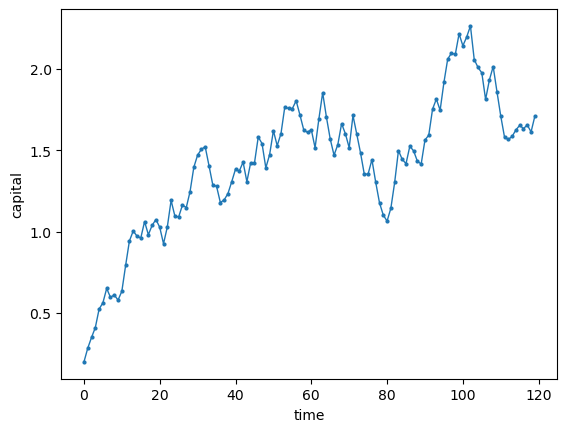

In [2]:
α, s, δ, a = 0.4, 0.3, 0.1, 1.0
n = 120
k =  np.empty(n)
k[0] = 0.2
for t in range(n-1):
    k[t+1] = np.random.rand() * s * k[t]**α + (1 - δ) * k[t]
    
fig, ax = plt.subplots()
ax.plot(k, 'o-', ms=2, lw=1)
ax.set_xlabel('time')
ax.set_ylabel('capital')
plt.show()

Let's say that we want to compute long-run average capital stock.

In [3]:
def solow(n=10_000_000, α=0.4, s=0.3, δ=0.1, k0=0.2):
    k = k0
    k_sum = k0
    for t in range(n):
        a = np.random.rand()
        k = a * s * k**α + (1 - δ) * k
        k_sum += k
    return k_sum / n

%time k = solow()
print(f"Steady-state capital = {k}.")

CPU times: user 3.11 s, sys: 18 µs, total: 3.11 s
Wall time: 3.11 s
Steady-state capital = 1.9545907051994431.


Steady-state capital:

Notice that the run-time is pretty slow.

Also, we can't use NumPy to accelerate it because there's no way to vectorize the loop.

Let's look at some alternatives.

### A Fortran version

We can make it fast if we rewrite it in Fortran.

To execute the following Fortran code on your machine, you need 

* a Fortran compiler (such as the open source `gfortran` compiler) and also
* the `fortranmagic` Jupyter extension, which can be installed by uncommenting

In [4]:
#!pip install fortran-magic

Now we load the extension (skip executing this and the rest of the section if you don't have a Fortran compiler).

In [5]:
%load_ext fortranmagic

In the following code, all parameters are the same as for the Python code above.

Now we add the cell magic ``%%fortran`` to a cell that contains a Fortran subroutine for the Solow-Swan computation:

In [6]:
%%fortran

subroutine solow_fortran(k0, s, delta, alpha, n, kt)
 implicit none
 integer, parameter :: dp=kind(0.d0) 
 integer, intent(in) :: n
 real(dp), intent(in) :: k0, s, delta, alpha
 real(dp), intent(out) :: kt
 real(dp) :: k, k_sum, a
 integer :: i
 k = k0
 k_sum = k0
 call random_seed
 do i = 1, n - 1      
  call random_number(a)
  k = a * s * k**alpha + (1 - delta) * k
  k_sum = k_sum + k
 end do
 kt = k_sum / real(n)
end subroutine solow_fortran 

Now we can call the function `solow_fortran` from Python.

(`fortranmagic` uses a program called `F2Py` to create a Python "wrapper" for the Fortran subroutine so we can access it from within Python.)

Let's make sure it gives the right answer.

In [7]:
n = 10_000_000
solow_fortran(0.2, s, δ, α, n)

1.953644416261124

Now let's time it:

In [8]:
%time solow_fortran(0.2, s, δ, α, n)

CPU times: user 249 ms, sys: 0 ns, total: 249 ms
Wall time: 248 ms


1.9543790420929275

Let's time it more carefully, over multiple runs:

In [9]:
%timeit solow_fortran(0.2, s, δ, α, n)

242 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The speed gain is about 1 order of magnitude.

## Numba

Now let's try the same thing in Python using Numba's JIT compilation.

We recall the Python function from above.

In [10]:
def solow(n=10_000_000, α=0.4, s=0.3, δ=0.1, k0=0.2):
    k =  k_sum = k0
    for t in range(n-1):
        a = np.random.rand()
        k = a * s * k**α + (1 - δ) * k
        k_sum += k
    return k

Now let's flag it for JIT-compilation:

In [11]:
solow_jitted = jit(solow)

And then run it:

In [12]:
%time k = solow_jitted()

CPU times: user 448 ms, sys: 4 ms, total: 452 ms
Wall time: 452 ms


In [13]:
%time k = solow_jitted()

CPU times: user 233 ms, sys: 0 ns, total: 233 ms
Wall time: 232 ms


In [14]:
%timeit k = solow_jitted()

234 ms ± 9.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Hopefully we get the same value:

In [15]:
k

1.6592987885470747

Here's the same thing using decorator notation.

In [16]:
@jit
def solow(n=10_000_000, α=0.4, s=0.3, δ=0.1, k0=0.2):
    k = k_sum = k0
    for t in range(n-1):
        a = np.random.rand()
        k = a * s * k**α + (1 - δ) * k
        k_sum += k
    return k_sum / n

In [17]:
%time k = solow()

CPU times: user 281 ms, sys: 14 µs, total: 281 ms
Wall time: 281 ms


In [18]:
%time k = solow()

CPU times: user 231 ms, sys: 3.88 ms, total: 235 ms
Wall time: 234 ms


After JIT compilation, function execution speed is about the same as Fortran.

#### How does it work?

The secret sauce is type inference inside the function body.

When we call `solow_jitted` with particular arguments, Numba's compiler works
through the function body and infers the types of the variables inside the
function.

It then produces compiled code *specialized to that type signature*

For example, we called `solow_jitted` with a `float, int` pair in the cell above and the compiler produced code specialized to those types.

That code runs fast because the compiler can fully specialize all operations inside the function based on that information and hence write very efficient machine code.

#### Limitations of Numba

Numba is great when it works but it can't compile functions that aren't
themselves JIT compiled.

In practice, this means we can't use most third party libraries:

In [19]:
from scipy.integrate import quad

def compute_integral(n):
    return quad(lambda x: x**(1/n), 0, 1)

This works fine if we don't jit the function.

In [20]:
compute_integral(4)

(0.8000000000000004, 8.881784197001256e-16)

But if we do...

In [21]:
@jit
def compute_integral(n):
    return quad(lambda x: x**(1/n), 0, 1)
        

In [22]:
compute_integral(4)

TypingError: Failed in nopython mode pipeline (step: convert make_function into JIT functions)
[1mCannot capture the non-constant value associated with variable 'n' in a function that may escape.
[1m
File "../../../../../../tmp/ipykernel_48891/3695301140.py", line 3:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

The reason is that the `quad` function is from SciPy and Numba doesn't know how
to handle it.

Key message: even though it might not be possible to JIT-compile your whole
program, you might well be able to compile the hot loops that are eating up 99%
of your computation time.

If you can do this, you open up large speed gains, as the following sections
make clear.

### Vectorization vs Numba

We made the point above that some problems are hard or impossible to vectorize and, in these situations, that we can use Numba instead of NumPy to accelerate our code.

However, there are also many situations where we *can* vectorize our code but Numba is still the better option.

Let's look at an example.

The problem is to maximize the function 

$$ f(x, y) = \frac{\cos \left(x^2 + y^2 \right)}{1 + x^2 + y^2} + 1$$

using brute force --- searching over a grid of $(x, y)$ pairs.

In [23]:
def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1

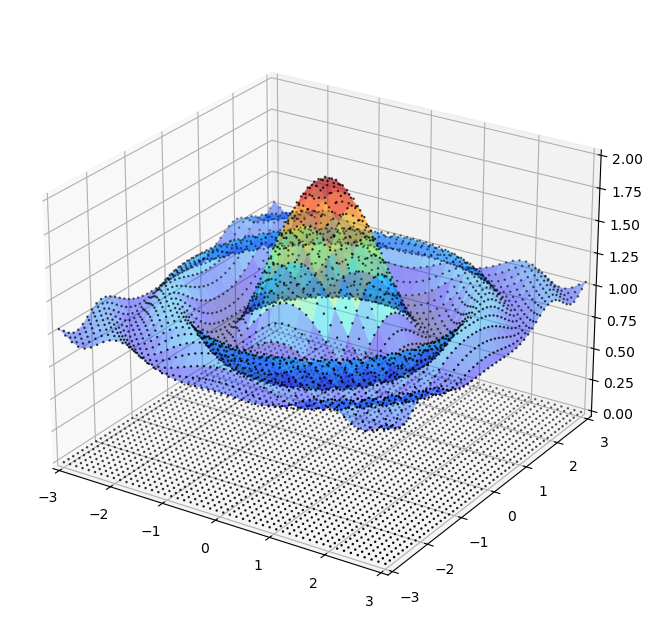

In [24]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

gridsize = 50
gmin, gmax = -3, 3
xgrid = np.linspace(gmin, gmax, gridsize)
ygrid = xgrid
x, y = np.meshgrid(xgrid, ygrid)

# === plot value function === #
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,
                y,
                f(x, y),
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.4,
                linewidth=0.05)


ax.scatter(x, y, c='k', s=0.6)

ax.scatter(x, y, f(x, y), c='k', s=0.6)

ax.view_init(25, -57)
ax.set_zlim(-0, 2.0)
ax.set_xlim(gmin, gmax)
ax.set_ylim(gmin, gmax)

plt.show()

#### Vectorized code

In [25]:
grid = np.linspace(-3, 3, 10_000)

In [26]:
x, y = np.meshgrid(grid, grid)

In [27]:
%%time
np.max(f(x, y))

CPU times: user 1.4 s, sys: 244 ms, total: 1.64 s
Wall time: 1.64 s


1.999999819964011

#### JITTed code

A jitted version -- note the speed gain.

In [28]:
@jit
def compute_max():
    m = -np.inf
    for x in grid:
        for y in grid:
            z = np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1
            if z > m:
                m = z
    return m

In [29]:
%%time
compute_max()

CPU times: user 1.03 s, sys: 3 µs, total: 1.03 s
Wall time: 1.02 s


1.999999819964011

In [30]:
%%time
compute_max()

CPU times: user 920 ms, sys: 101 µs, total: 920 ms
Wall time: 918 ms


1.999999819964011

#### JITTed, parallelized code: @vectorize


Numba for vectorization with automatic parallization - even faster:

In [31]:
signature = 'float64(float64, float64)'  # A function sending (float, float) into float

@vectorize(signature, target='parallel')
def f_par(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1

In [32]:
x, y = np.meshgrid(grid, grid)

np.max(f_par(x, y))

1.999999819964011

In [33]:
%%time
np.max(f_par(x, y))

CPU times: user 2.19 s, sys: 242 ms, total: 2.43 s
Wall time: 188 ms


1.999999819964011

In [34]:
%%time
np.max(f_par(x, y))

CPU times: user 2.24 s, sys: 212 ms, total: 2.46 s
Wall time: 190 ms


1.999999819964011